In [16]:
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import numpy as np
from scipy.special import erf
import h5py
import os
from unyt import angstrom, Msun, yr, m, erg, s, Hz

from synthesizer.grid import Grid
from synthesizer import Sed

import swiftascmaps
import cmasher as cmr


plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

def get_n_colors_from_cmap(n, cmap_name="viridis"):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i) for i in np.linspace(0, 0.9, n)]
    return colors

In [3]:
subvolumes = [
    "0_0_0",
    "0_0_1",
    "0_1_0",
    "0_1_1",
    "1_0_0",
    "1_0_1",
    "1_1_0",
    "1_1_1"
]

subvolumes = ["0_0_0"]  # keep only the ones you want

pipeline_dir = '/mnt/home/snewman/ceph/pipeline_results/combined'
pipeline_name = 'pipeline_nodust_mdotcut_subradio'

grp_total = 'Galaxies/Spectra/SpectralLuminosityDensities/total'
grp_bh = 'Galaxies/BlackHoles/Spectra/SpectralLuminosityDensities/agn_incident'
grp_star = 'Galaxies/Stars/Spectra/SpectralLuminosityDensities/stellar_incident'

spectra = np.concatenate([
    h5py.File(os.path.join(pipeline_dir, f'{pipeline_name}_{subvol}.hdf5'), 'r')[f'{grp_total}'][:]
    for subvol in subvolumes
])

bh_spectra = np.concatenate([
    h5py.File(os.path.join(pipeline_dir, f'{pipeline_name}_{subvol}.hdf5'), 'r')[f'{grp_bh}'][:]
    for subvol in subvolumes
])

star_spectra = np.concatenate([
    h5py.File(os.path.join(pipeline_dir, f'{pipeline_name}_{subvol}.hdf5'), 'r')[f'{grp_star}'][:]
    for subvol in subvolumes
])

# Manually add the bh and star spectra to get total
spectra_manual = bh_spectra + star_spectra

# Get accretion rates 
accretion_rates = np.concatenate([
    h5py.File(os.path.join(pipeline_dir, f'{pipeline_name}_{subvol}.hdf5'), 'r')['Galaxies/AccretionRate'][:]
    for subvol in subvolumes
]) 

# Get BH masses
bh_masses = np.concatenate([
    h5py.File(os.path.join(pipeline_dir, f'{pipeline_name}_{subvol}.hdf5'), 'r')['Galaxies/BlackHoleMass'][:]
    for subvol in subvolumes
])

print(spectra.shape)
print(bh_spectra.shape)
print(star_spectra.shape)
print(spectra_manual.shape)
print(accretion_rates.shape)
print(bh_masses.shape)

(5064, 100000)
(5064, 100000)
(5064, 100000)
(5064, 100000)
(5064, 1)
(5064, 1)


In [19]:
# Make synthesizer SED object

wavelengths = np.logspace(0.1, 6, 100000) * angstrom

sed = Sed(wavelengths, spectra * erg / (s * Hz))

B_band_window_limits = (3646 * angstrom, 6936 * angstrom)

B_lum = sed.measure_window_luminosity(B_band_window_limits)

print(B_lum.shape)


[Python] Creating Sed took: 0.000494 seconds
(5064,)


/tmp/ipykernel_3691834/2652820139.py:19: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wavelengths), np.log10(spectra[idx]), lw=2,


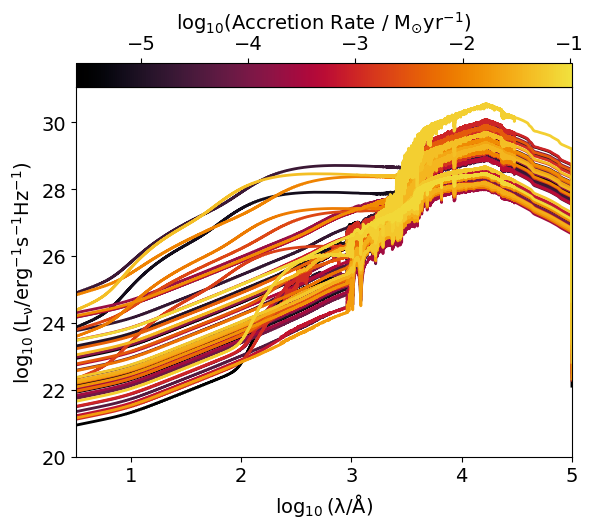

In [4]:
# Get wavelengths from the AGN grid
wavelengths = np.logspace(0.1, 6, 100000) * angstrom

# Pick random galaxies
gal_idx = np.random.choice(spectra.shape[0], 50, replace=False)

log_selected_mdots = np.log10(accretion_rates[gal_idx])

fig, ax = plt.subplots()

# Create a colormap based on accretion rates
cmap = cmr.ember
norm = mpl.colors.Normalize(vmin=min(log_selected_mdots), vmax=max(log_selected_mdots))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
colors = cmap(norm(log_selected_mdots))

for i, idx in enumerate(gal_idx):
    plt.plot(np.log10(wavelengths), np.log10(spectra[idx]), lw=2,
             color = cmap(i/len(log_selected_mdots)))
    
plt.xlabel(r"Wavelength ($\AA$)")
plt.xlabel(r"$\rm \log_{10}(\lambda / \AA$)")
plt.ylabel(r'$\rm \log_{10}(L_{\nu}/erg^{-1} s^{-1} Hz^{-1})$')
plt.xlim(left=0.5, right=5)
plt.ylim(bottom=20)

# Create colorbar axis
left = 0.125
bottom = 0.8
width = 0.775
height = 0.08
cax = fig.add_axes([left, bottom + height, width, 0.05])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cax.xaxis.tick_top()
cax.xaxis.set_label_position("top")
cax.set_xlabel(r"$ \rm log_{10}$(Accretion Rate / $\rm M_{\odot} yr^{-1}$)")

plt.show()

/tmp/ipykernel_3508333/1650507835.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wavelengths), np.log10(spectra[idx]), lw=2,


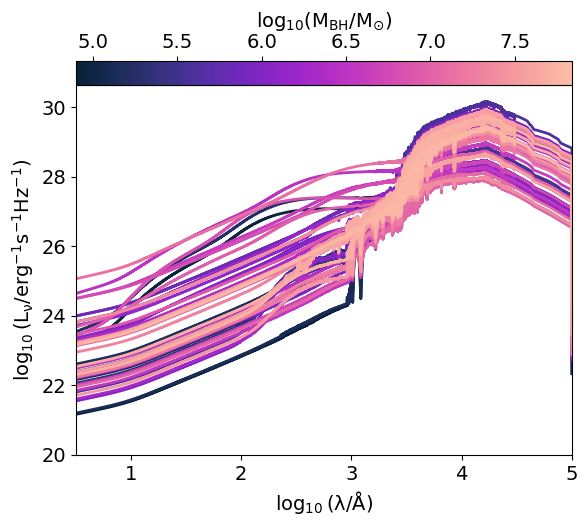

In [4]:
# Get wavelengths from the AGN grid
wavelengths = np.logspace(0.1, 6, 100000) * angstrom

# Pick random galaxies
gal_idx = np.random.choice(spectra.shape[0], 50, replace=False)

log_selected_masses = np.log10(bh_masses[gal_idx])

fig, ax = plt.subplots()

# Create a colormap based on BH masses
cmap = cmr.bubblegum
norm = mpl.colors.Normalize(vmin=min(log_selected_masses), vmax=max(log_selected_masses))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for i, idx in enumerate(gal_idx):
    plt.plot(np.log10(wavelengths), np.log10(spectra[idx]), lw=2,
             color = cmap(i/len(log_selected_masses)))
    
plt.xlabel(r"$\rm \log_{10}(\lambda / \AA$)")
plt.ylabel(r'$\rm \log_{10}(L_{\nu}/erg^{-1} s^{-1} Hz^{-1})$')
plt.xlim(left=0.5, right=5)
plt.ylim(bottom=20)

# Create colorbar axis
left = 0.125
bottom = 0.8
width = 0.775
height = 0.08
cax = fig.add_axes([left, bottom + height, width, 0.05])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cax.xaxis.tick_top()
cax.xaxis.set_label_position("top")
cax.set_xlabel(r"$ \rm log_{10} (M_{BH}/M_{\odot})$")

plt.show()

[4594 4943 1877 4474 1650 1572 4661 2731 1436 3330  619 4776 2982  905
 4566 3306 2312 1318 4061 3924 3425 1297  747  581 4824 1905  178 3608
 4590 2762 1076 2893 1102 1977 3855  570 4243 3723   10 2084  990  884
 4528 3533 1082 3675 4472 1709 1786 3127 3750   26 2299 2353 3710 5016
 1075  499 1300 4884 3716 1085 4543 3746 3701 4517  239 1736 2412  302
 2364 1537 4245 2943 4839  173 1890  865    6  802  772 2125 2215 3908
 4682 3073 4521  809 4038 2329 1513 4120 1965 1452 1045 1899  290 2358
 3205  741]


/tmp/ipykernel_3508333/2644172499.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wavelengths), np.log10(spectra[i]), lw=lw, label='Total', color=color_total, zorder=3)
/tmp/ipykernel_3508333/2644172499.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wavelengths), np.log10(bh_spectra[i]), lw=lw, label='BH', color=color_bh)
/tmp/ipykernel_3508333/2644172499.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wavelengths), np.log10(star_spectra[i]), lw=lw, label='Stars', color=color_star)


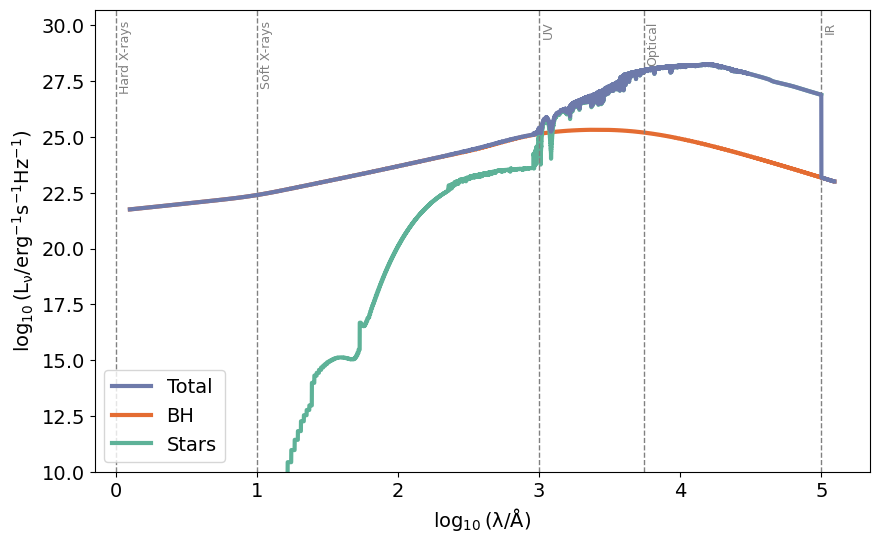

In [5]:
# Pick random galaxies
gal_idx = np.random.choice(spectra.shape[0], 100, replace=False)
print(gal_idx)

plt.figure(figsize=(10, 6))
lw = 3
color_bh = '#e46c32'
color_star = '#5eb298'
color_total = '#6e7aaa'

i = gal_idx[0]

plt.plot(np.log10(wavelengths), np.log10(spectra[i]), lw=lw, label='Total', color=color_total, zorder=3)
plt.plot(np.log10(wavelengths), np.log10(bh_spectra[i]), lw=lw, label='BH', color=color_bh)
plt.plot(np.log10(wavelengths), np.log10(star_spectra[i]), lw=lw, label='Stars', color=color_star)

# Add reference wavelength bands
bands = {
    'Hard X-rays': 1,        # ~1 Å
    'Soft X-rays': 10,       # ~10 Å
    'UV': 1000,              # ~1000 Å
    'Optical': 5500,         # ~5500 Å
    'IR': 100000,            # ~1e5 Å (10 µm)
}

for label, lam in bands.items():
    plt.axvline(np.log10(lam), color='gray', ls='--', lw=1)
    plt.text(np.log10(lam) + 0.02, plt.ylim()[1] - 0.5, label,
             rotation=90, va='top', ha='left', fontsize=9, color='gray')


plt.xlabel(r"$\rm \log_{10}(\lambda / \AA$)")
plt.ylabel(r'$\rm \log_{10}(L_{\nu}/erg^{-1} s^{-1} Hz^{-1})$')
#plt.xlim(left=-0.01)
plt.ylim(bottom=10)
plt.legend()
plt.show()

Using wavelength index 51887 wavelength (m) = 1449.9853476467495 Å -> (Å) = 1449.9853476467495 dimensionless


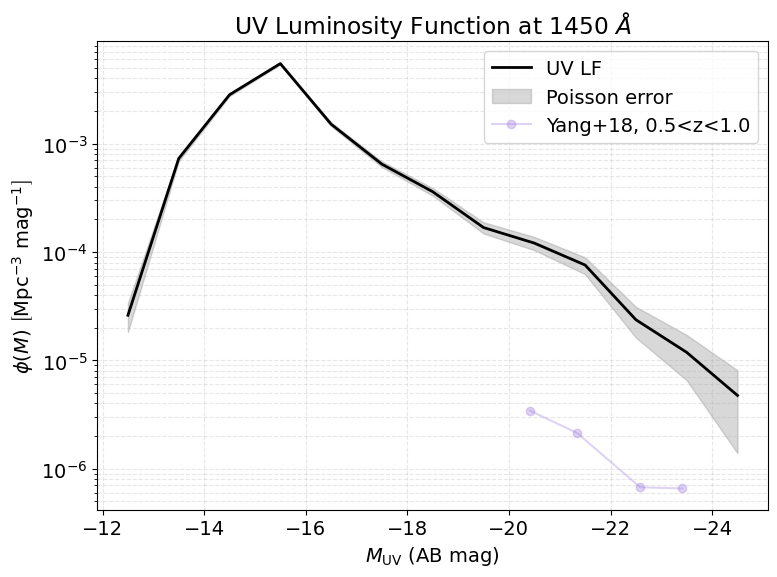

M = -24.50  phi = 4.741e-06 +/- 3.352e-06  (counts=2)
M = -23.50  phi = 1.185e-05 +/- 5.300e-06  (counts=5)
M = -22.50  phi = 2.370e-05 +/- 7.496e-06  (counts=10)
M = -21.50  phi = 7.585e-05 +/- 1.341e-05  (counts=32)
M = -20.50  phi = 1.209e-04 +/- 1.693e-05  (counts=51)
M = -19.50  phi = 1.683e-04 +/- 1.997e-05  (counts=71)
M = -18.50  phi = 3.603e-04 +/- 2.922e-05  (counts=152)
M = -17.50  phi = 6.471e-04 +/- 3.916e-05  (counts=273)
M = -16.50  phi = 1.515e-03 +/- 5.992e-05  (counts=639)
M = -15.50  phi = 5.490e-03 +/- 1.141e-04  (counts=2316)
M = -14.50  phi = 2.830e-03 +/- 8.191e-05  (counts=1194)
M = -13.50  phi = 7.301e-04 +/- 4.160e-05  (counts=308)
M = -12.50  phi = 2.607e-05 +/- 7.862e-06  (counts=11)


In [6]:
# Box size in Mpc
box_size_mpc = 150

# Choose UV reference wavelength (1500 Å)
uv_ref = 1450 * angstrom 

# find index in wavelengths closest to 1500 Å
uv_idx = np.argmin(np.abs(wavelengths - uv_ref))
print("Using wavelength index", uv_idx, "wavelength (m) =", wavelengths[uv_idx], "-> (Å) =", wavelengths[uv_idx]/angstrom)

# Extract L_nu at 1500 Å for all galaxies
Lnu_uv = spectra[:, uv_idx].astype(float) 

# If there are non-positive values, remove them (can't take log)
mask_positive = Lnu_uv > 0
if np.sum(~mask_positive) > 0:
    print(f"Warning: {np.sum(~mask_positive)} galaxies have non-positive Lnu; they will be excluded.")
Lnu_uv = Lnu_uv[mask_positive]

# Convert L_nu [erg s^-1 Hz^-1] to M_AB (AB absolute magnitude)
Muv = -2.5 * np.log10(Lnu_uv) + 51.60

# Set magnitude bins (adjust range & bin width to your data)
bin_width = 1
mag_min, mag_max = np.floor(Muv.min()) - 1, np.ceil(Muv.max()) + 1
bins = np.arange(mag_min, mag_max + bin_width, bin_width)
hist, edges = np.histogram(Muv, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# Compute comoving volume 
volume_mpc3 = box_size_mpc**3 / 8  # Mpc^3

# Convert counts to number density phi(M) [Mpc^-3 mag^-1]
phi = hist / (volume_mpc3 * bin_width)

# Poisson errors on counts -> sigma_phi = sqrt(N) / (V * bin_width)
sigma_phi = np.sqrt(hist) / (volume_mpc3 * bin_width)

# For plotting, avoid zeros when using log
positive = phi > 0

# Plot LF as line with shaded error
plt.figure(figsize=(8,6))

plt.plot(bin_centers[positive], phi[positive], color="k", lw=2, label="UV LF")
plt.fill_between(bin_centers[positive],
                 phi[positive] - sigma_phi[positive],
                 phi[positive] + sigma_phi[positive],
                 color="gray", alpha=0.3, label="Poisson error")



# Plot observational data

# Plot x from Shen+20

obs_points = [
    (-23.40893470790378, 6.572163109701064e-7),
    (-22.58419243986254, 6.731703824144982e-7),
    (-21.347079037800686, 2.1287516617963725e-6),
    (-20.412371134020617, 3.439207136848946e-6)
]

obs_x, obs_phi = zip(*obs_points)

plt.plot(obs_x, obs_phi, marker='o', ls=None, color='mediumpurple', alpha=0.3, label='Yang+18, 0.5<z<1.0')



plt.yscale('log')
plt.xlabel(r'$M_{\rm UV}$ (AB mag)')
plt.ylabel(r'$\phi(M)\ \left[\mathrm{Mpc}^{-3}\ \mathrm{mag}^{-1}\right]$')
plt.title(r'UV Luminosity Function at 1450 $\AA$')
plt.gca().invert_xaxis()   # brighter mags to the left
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print some numbers for reference
for m, p, s in zip(bin_centers[positive], phi[positive], sigma_phi[positive]):
    print(f"M = {m:.2f}  phi = {p:.3e} +/- {s:.3e}  (counts={int((p*volume_mpc3*bin_width))})")

Using wavelength index 60058 wavelength (m) = 1449.9853476467495 Å -> (Å) = 1449.9853476467495 dimensionless


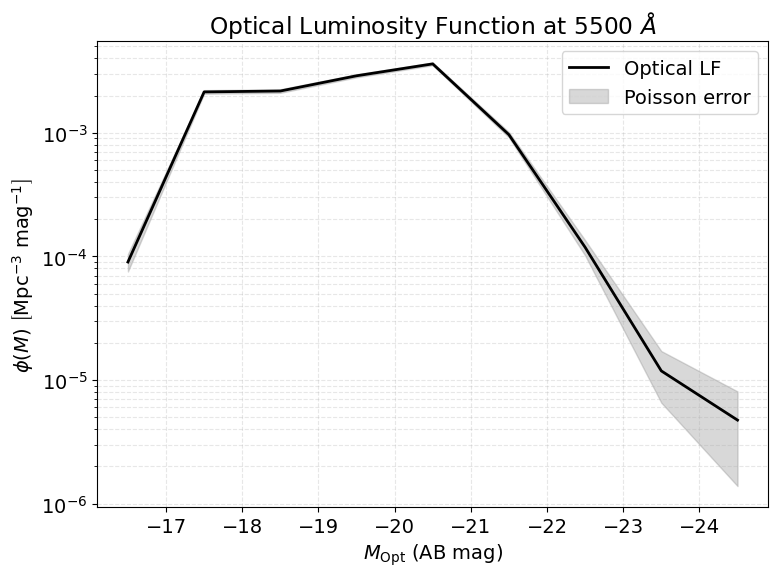

M = -24.50  phi = 4.741e-06 +/- 3.352e-06  (counts=2)
M = -23.50  phi = 1.185e-05 +/- 5.300e-06  (counts=5)
M = -22.50  phi = 1.185e-04 +/- 1.676e-05  (counts=50)
M = -21.50  phi = 9.647e-04 +/- 4.782e-05  (counts=407)
M = -20.50  phi = 3.608e-03 +/- 9.247e-05  (counts=1522)
M = -19.50  phi = 2.889e-03 +/- 8.276e-05  (counts=1219)
M = -18.50  phi = 2.176e-03 +/- 7.182e-05  (counts=918)
M = -17.50  phi = 2.140e-03 +/- 7.123e-05  (counts=903)
M = -16.50  phi = 9.007e-05 +/- 1.461e-05  (counts=38)


In [11]:
# Box size in Mpc
box_size_mpc = 150

# Choose optical reference wavelength
opt_ref = 4400 * angstrom 

# find index in wavelengths closest to 1500 Å
opt_idx = np.argmin(np.abs(wavelengths - opt_ref))
print("Using wavelength index", opt_idx, "wavelength (m) =", wavelengths[uv_idx], "-> (Å) =", wavelengths[uv_idx]/angstrom)

# Extract L_nu at 1500 Å for all galaxies
Lnu_opt = spectra[:, opt_idx].astype(float) 

# If there are non-positive values, remove them (can't take log)
mask_positive = Lnu_opt > 0
if np.sum(~mask_positive) > 0:
    print(f"Warning: {np.sum(~mask_positive)} galaxies have non-positive Lnu; they will be excluded.")
Lnu_opt = Lnu_opt[mask_positive]

# Convert L_nu [erg s^-1 Hz^-1] to M_AB (AB absolute magnitude)
Mopt = -2.5 * np.log10(Lnu_opt) + 51.60

# Set magnitude bins (adjust range & bin width to your data)
bin_width = 1
mag_min, mag_max = np.floor(Mopt.min()) - 1, np.ceil(Mopt.max()) + 1
bins = np.arange(mag_min, mag_max + bin_width, bin_width)
hist, edges = np.histogram(Mopt, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# Compute comoving volume 
volume_mpc3 = box_size_mpc**3 / 8  # Mpc^3

# Convert counts to number density phi(M) [Mpc^-3 mag^-1]
phi = hist / (volume_mpc3 * bin_width)

# Poisson errors on counts -> sigma_phi = sqrt(N) / (V * bin_width)
sigma_phi = np.sqrt(hist) / (volume_mpc3 * bin_width)

# For plotting, avoid zeros when using log
positive = phi > 0

# Plot LF as line with shaded error
plt.figure(figsize=(8,6))

plt.plot(bin_centers[positive], phi[positive], color="k", lw=2, label="Optical LF")
plt.fill_between(bin_centers[positive],
                 phi[positive] - sigma_phi[positive],
                 phi[positive] + sigma_phi[positive],
                 color="gray", alpha=0.3, label="Poisson error")



plt.yscale('log')
plt.xlabel(r'$M_{\rm Opt}$ (AB mag)')
plt.ylabel(r'$\phi(M)\ \left[\mathrm{Mpc}^{-3}\ \mathrm{mag}^{-1}\right]$')
plt.title(r'Optical Luminosity Function at 5500 $\AA$')
plt.gca().invert_xaxis()   # brighter mags to the left
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print some numbers for reference
for m, p, s in zip(bin_centers[positive], phi[positive], sigma_phi[positive]):
    print(f"M = {m:.2f}  phi = {p:.3e} +/- {s:.3e}  (counts={int((p*volume_mpc3*bin_width))})")

B_Band
logL_bol: [46.700977   46.58300541 46.46515705 46.34744303 46.22987532 46.11246676
 45.99523112 45.87818313 45.76133846 45.64471375 45.52832663 45.41219568
 46.224001   46.12615578 46.02842949 45.93083053 45.83336775 45.73605051
 45.6388886  45.54189229 45.44507233 45.34843988 45.25200657 45.15578442
 45.05978584 44.96402358]
log_phi: [-7.05852169 -6.74027116 -6.50210639 -6.27429082 -5.97702852 -5.72047242
 -5.51471307 -5.28981778 -5.10570989 -4.96228152 -4.76937973 -5.27675959
 -5.60902057 -5.47234536 -5.32102343 -5.21303283 -5.06375413 -4.7126282
 -4.68655691 -4.77472845 -4.46350721 -4.26227037 -4.2971259  -4.15525307
 -4.19470851 -4.19132875]
Hard_Xray
logL_bol: [43.69294666 44.51476482 45.13388981 45.84369535 46.31738862 46.88953254
 47.4783108  43.75612192 45.05424363 46.39890274 47.76666453 43.53652528
 44.17186133 44.82363333 45.48822066 46.16213185 46.84247497 43.56329093
 44.1993976  44.85179269 45.51684662 46.19108662 46.87165131 42.31034708
 42.75420305 43.20993028 43

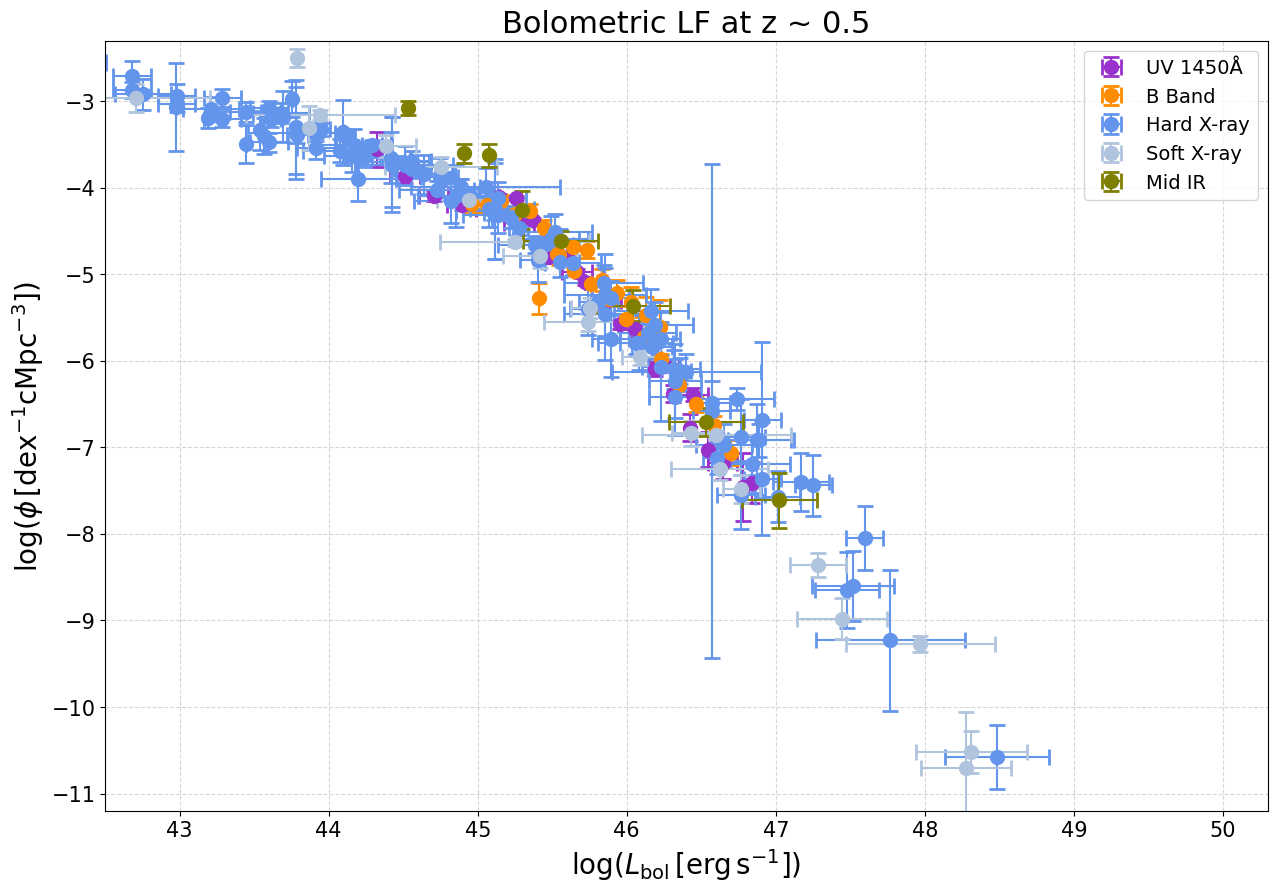

In [5]:
# File containing data from QUASARLF (Shen+20)
redshift = 0.5
bol_dir = "/mnt/home/snewman/ceph"
output_file = f"{bol_dir}/bolometric_data_z{redshift}.h5"

# Define colors and labels for each dataset
dataset_info = {
    "UV_1450A": {"color": "darkorchid", "label": "UV 1450Å"},
    "B_Band": {"color": "darkorange", "label": "B Band"},
    "Hard_Xray": {"color": "cornflowerblue", "label": "Hard X-ray"},
    "Soft_Xray": {"color": "lightsteelblue", "label": "Soft X-ray"},
    "Mid_IR": {"color": "olive", "label": "Mid IR"},
}

# Create plot
fig, ax = plt.subplots(figsize=(15,10))

with h5py.File(output_file, "r") as hf:

    # Quickly check the file contents to see what datasets are available
    for name in hf.keys():
        print(name)
        print("logL_bol:", hf[name]["logL_bol"][:])
        print("log_phi:", hf[name]["log_phi"][:])

    # Plot each dataset
    for name, info in dataset_info.items():
        group = hf[name]
        x = group["logL_bol"][:]
        y = group["log_phi"][:]
        dy = group["d_phi"][:]
        dx = group["d_L"][:]

        # Replace zeroes in dx with a small positive number to avoid log(0)
        dx[dx <= 0] = 1e-9  # small positive number

        ax.errorbar(x, y, yerr=dy, xerr=dx, fmt='o', markersize=10,
                    color=info["color"], ecolor=info["color"], 
                    capsize=6, capthick=2, label=info["label"])

ax.set_xlabel(r'$\log(L_{\rm bol} \,[\rm erg\,s^{-1}])$', fontsize=20)
ax.set_ylabel(r'$\log(\phi \,[\rm dex^{-1} cMpc^{-3}])$', fontsize=20)
ax.set_xlim(42.5, 50.3)
ax.set_ylim(-11.2, -2.3)
ax.tick_params(labelsize=15)
ax.legend(fontsize=14)
ax.grid(True, linestyle='--', alpha=0.5)

plt.title(f"Bolometric LF at z ~ {redshift}", fontsize=22)
plt.show()

Datasets found: ['B_Band', 'Hard_Xray', 'Mid_IR', 'Soft_Xray', 'UV_1450A']
Loaded 202 total points from Shen+20


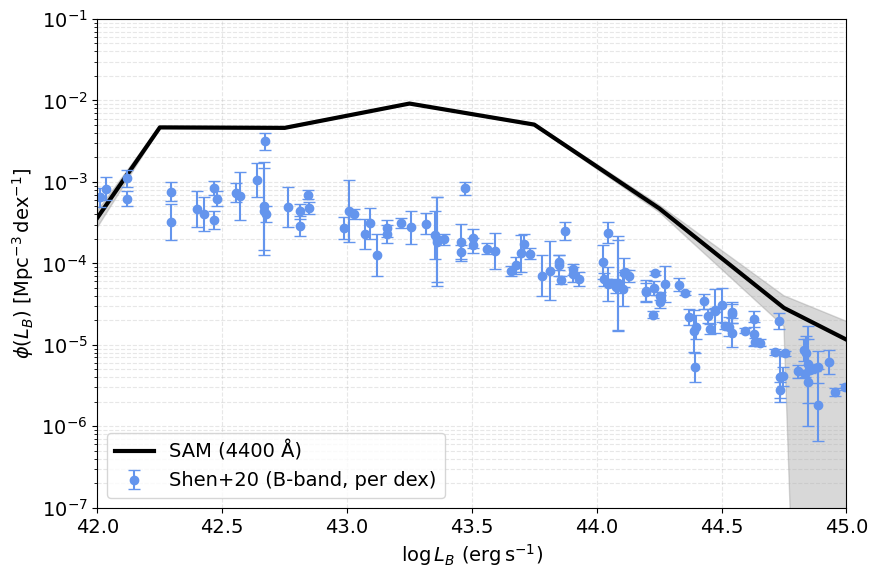

In [23]:
# =========================
#  OBSERVATIONAL DATA (Shen+20)
# =========================

L_SUN = 3.828e33   # erg/s
SHEN_FILE = "/mnt/home/snewman/ceph/bolometric_data_z0.5.h5"
REDSHIFT = 0.5

def bolometric_corrections(L_bol):
    """Bolometric correction relations from Shen+20."""
    L_bol = np.asarray(L_bol, dtype=np.float64)
    params = {
        'B': {'c1': 3.759, 'k1': -0.361, 'c2': 9.830, 'k2': -0.0063},
        'UV': {'c1': 1.862, 'k1': -0.361, 'c2': 4.870, 'k2': -0.0063},
        'Xsoft': {'c1': 5.712, 'k1': -0.026, 'c2': 17.67, 'k2': 0.278},
        'Xhard': {'c1': 4.073, 'k1': -0.026, 'c2': 12.60, 'k2': 0.278},
        'IR': {'c1': 4.361, 'k1': -0.361, 'c2': 11.40, 'k2': -0.0063},
    }
    result = {}
    for band, p in params.items():
        ratio = (L_bol / (L_SUN * 1e10))
        denom = p['c1'] * ratio**p['k1'] + p['c2'] * ratio**p['k2']
        result[band] = L_bol / denom
    return result


# --- Load Shen+20 data ---
logL_bol_list, logphi_list, dlogphi_list = [], [], []
with h5py.File(SHEN_FILE, "r") as hf:
    print("Datasets found:", list(hf.keys()))
    for name in hf.keys():
        g = hf[name]
        logL_bol_list.append(g["logL_bol"][:])
        logphi_list.append(g["log_phi"][:])
        dlogphi_list.append(g["d_phi"][:])

# Combine all datasets
logL_bol = np.concatenate(logL_bol_list)
logphi = np.concatenate(logphi_list)
dlogphi = np.concatenate(dlogphi_list)
print(f"Loaded {len(logL_bol)} total points from Shen+20")

# Convert bolometric to B-band luminosities
L_bol = 10**logL_bol
L_B = bolometric_corrections(L_bol)['B']
logL_B = np.log10(L_B)

# Linearize phi (per dex)
phi = 10**logphi
phi_upper = 10**(logphi + dlogphi) - phi
phi_lower = phi - 10**(logphi - dlogphi)

# =========================
#  SIMULATION DATA (SAM)
# =========================

BOX_SIZE = 150.0        # Mpc
VOLUME = BOX_SIZE**3 / 8

opt_ref = 4400 * angstrom   # meters
opt_idx = np.argmin(np.abs(wavelengths - opt_ref))
Lnu_opt = spectra[:, opt_idx].astype(float)
Lnu_opt = Lnu_opt[Lnu_opt > 0]   # remove negatives

# Convert from L_nu (erg/s/Hz) to integrated L_B (erg/s)
# Just multiply by effective ν 
nu_B = 3e18 / 4400.0   # Hz
L_B_sim = Lnu_opt * nu_B
logL_B_sim = np.log10(L_B_sim)

logL_B_sim = np.log10(B_lum)

# Bin in dex
DEX_WIDTH = 0.5
bins = np.arange(np.floor(logL_B_sim.min()), np.ceil(logL_B_sim.max()) + DEX_WIDTH, DEX_WIDTH)
hist, edges = np.histogram(logL_B_sim, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

phi_sim = hist / (VOLUME * DEX_WIDTH)
sigma_phi_sim = np.sqrt(hist) / (VOLUME * DEX_WIDTH)

# =========================
#  PLOT COMPARISON
# =========================

plt.figure(figsize=(9, 6))

# SAM data
plt.plot(bin_centers, phi_sim, color='k', lw=3, label='SAM (4400 Å)')
plt.fill_between(bin_centers, np.maximum(phi_sim - sigma_phi_sim, 1e-50),
                 phi_sim + sigma_phi_sim, color='gray', alpha=0.3)

# Shen+20 observational LF
sel = np.isfinite(phi) & (phi > 0)
yerr = np.vstack((phi_lower[sel], phi_upper[sel]))

plt.errorbar(logL_B[sel], phi[sel], yerr=yerr,
             fmt='o', color='cornflowerblue', capsize=4,
             label='Shen+20 (B-band, per dex)')

plt.yscale('log')
plt.xlabel(r'$\log L_B\ (\mathrm{erg\,s^{-1}})$')
plt.ylabel(r'$\phi(L_B)\ [\mathrm{Mpc^{-3}\,dex^{-1}}]$')
plt.xlim(np.ceil(bin_centers.min()), np.floor(bin_centers.max()))
plt.ylim(bottom=1e-7, top=1e-1)
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()
